# 1. Importaciones, carga de datos y configuración

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications, optimizers

import matplotlib.pyplot as plt

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [2]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

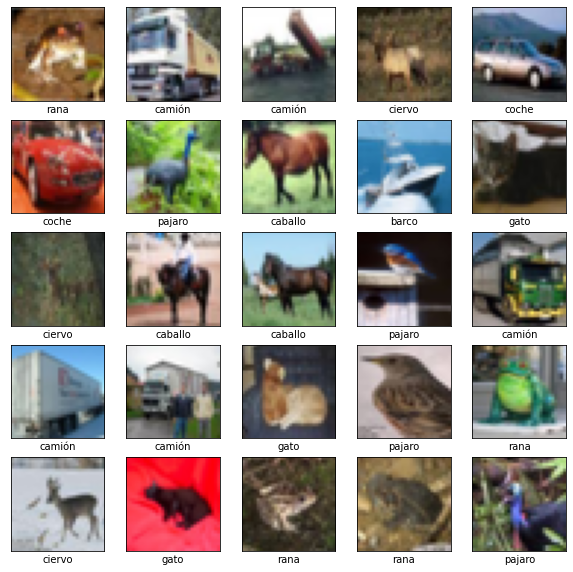

In [19]:
class_names = ['avión', 'coche', 'pajaro', 'gato', 'ciervo',
               'dog', 'rana', 'caballo', 'barco', 'camión']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# 2. Transfer Learning
Consiste en una arquitectura en la que los pesos han sido entrendos y quitamos las últimas capas (lo que se llama cabecera) para poner las nuestras, que son las que representan nuestro problema específico.

In [9]:
X_train = applications.efficientnet.preprocess_input(X_train)
X_test = applications.efficientnet.preprocess_input(X_test)

inputs = layers.Input(shape=(32,32,3))
upscale = layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                            240,
                                                            240,
                                                            method=tf.image.ResizeMethod.BILINEAR))(inputs)

tl_efn_model = applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor = upscale, input_shape=(240, 240, 3))
tl_efn_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 240, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 240, 3)  7           rescaling[0][0]                  
_____________________________________________________________________________________

In [10]:
#Ponemos las capas como no entrenables
for layer in tl_efn_model.layers: layer.trainable = False
print(f"Número total de capas:{len(tl_efn_model.layers)}")

Número total de capas:238


In [14]:
#Configuración
LR = 0.002
EPOCHS = 10
BATCH = 128
CLASES = 10

In [9]:
extractor_características = tl_efn_model.output
maxpool = layers.GlobalMaxPooling2D()(extractor_características)
ultima_capa = layers.Dense(CLASES, activation="softmax")(maxpool)

modelo_tl = models.Model(inputs=inputs, outputs=ultima_capa)

opt = optimizers.Adam(lr=LR)
modelo_tl.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [10]:
history = modelo_tl.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 85s 203ms/step - loss: 1.6699 - sparse_categorical_accuracy: 0.5983 - val_loss: 0.5282 - val_sparse_categorical_accuracy: 0.8376
Epoch 2/10
391/391 [==============================] - 77s 197ms/step - loss: 0.5795 - sparse_categorical_accuracy: 0.8185 - val_loss: 0.4534 - val_sparse_categorical_accuracy: 0.8588
Epoch 3/10
391/391 [==============================] - 77s 198ms/step - loss: 0.5024 - sparse_categorical_accuracy: 0.8375 - val_loss: 0.4352 - val_sparse_categorical_accuracy: 0.8658
Epoch 4/10
391/391 [==============================] - 77s 198ms/step - loss: 0.4452 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.4219 - val_sparse_categorical_accuracy: 0.8645
Epoch 5/10
391/391 [==============================] - 77s 198ms/step - loss: 0.4144 - sparse_categorical_accuracy: 0.8641 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8730
Epoch 6/10
391/391 [==============================] - 77s 198ms/step - loss: 0.4162 -

# 3. Fine Tuning

In [13]:
inputs = layers.Input(shape=(32,32,3))
upscale = layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                            240,
                                                            240,
                                                            method=tf.image.ResizeMethod.BILINEAR))(inputs)

fn_efn_model = applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor = upscale, input_shape=(240, 240, 3))

#Entrenamos las últimas 38 capas
for layer in fn_efn_model.layers[:-38]: layer.trainable = False

In [16]:
extractor_características = fn_efn_model.output
maxpool = layers.GlobalMaxPooling2D()(extractor_características)
ultima_capa = layers.Dense(CLASES, activation="softmax")(maxpool)

modelo_fn = models.Model(inputs=inputs, outputs=ultima_capa)

opt = optimizers.Adam(lr=LR)
modelo_fn.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
modelo_fn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 240, 240, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 240, 240, 3)  0           lambda_3[0][0]                   
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 240, 240, 3)  7           rescaling_3[0][0]                
____________________________________________________________________________________________

In [18]:
history = modelo_fn.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 102s 238ms/step - loss: 1.0105 - sparse_categorical_accuracy: 0.7800 - val_loss: 0.2442 - val_sparse_categorical_accuracy: 0.9222
Epoch 2/10
391/391 [==============================] - 91s 232ms/step - loss: 0.2344 - sparse_categorical_accuracy: 0.9196 - val_loss: 0.2505 - val_sparse_categorical_accuracy: 0.9251
Epoch 3/10
391/391 [==============================] - 91s 233ms/step - loss: 0.1764 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.2255 - val_sparse_categorical_accuracy: 0.9267
Epoch 4/10
391/391 [==============================] - 94s 240ms/step - loss: 0.1442 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.2200 - val_sparse_categorical_accuracy: 0.9338
Epoch 5/10
391/391 [==============================] - 98s 252ms/step - loss: 0.1138 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.2310 - val_sparse_categorical_accuracy: 0.9327
Epoch 6/10
391/391 [==============================] - 96s 245ms/step - loss: 0.1031 